In [4]:
import os
data_folder = "../input/uw-madison-gi-tract-image-segmentation/" if os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "") else "./data/"

# List all imports below
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scv_utility import *
from unet import *
import torch

np.random.seed(0)
torch.manual_seed(0)
pd.set_option("display.width", 120)

In [5]:
# Load small train and test datasets
data = pd.read_csv(data_folder + "train.csv", converters={"id": str, "class": str, "segmentation": str})
print(f"Classes in train set: {data['class'].unique()}")

train_cases = ["case2_", "case7_", "case15_", "case20_", "case22_", "case24_", "case29_", "case30_", "case32_", "case123_"]
test_cases = ["case156_", "case154_", "case149_"]
train_data = data[data["id"].str.contains("|".join(train_cases))]
test_data = data[data["id"].str.contains("|".join(test_cases))]
print(f"Number of train images: {len(train_data['id'].unique())}, test images: {len(test_data['id'].unique())}")

Classes in train set: ['large_bowel' 'small_bowel' 'stomach']
Number of train images: 4320, test images: 1584


In [6]:
# Analyze train and test dataset to assure they have the same resolution
for sample_id in np.concatenate((train_data["id"].unique(), test_data["id"].unique())):
    try:
        sample_image, sample_image_res, sample_pixel_size = get_image_data_from_id(sample_id, data_folder)
#         print(f"Image shape: {sample_image.shape}, reported resolution: {sample_image_res}, reported pixel size: {sample_pixel_size}")
        assert sample_image_res == (266, 266) and sample_pixel_size == 1.50, "Incorrect resolution or pixel size"
    except Exception as e:
        print(f"Exception {e} while reading image {sample_id}")
print("Dataset analysis successfull")

Dataset analysis successfull


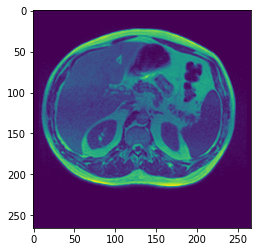

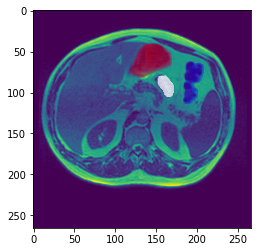

In [7]:
# Display an example of a converted run-length encoding
example_id = "case123_day20_slice_0085"

# Extract the necessary data
sample_image, sample_image_res, _ = get_image_data_from_id(example_id, data_folder)
rle_stomach = extract_rle(data, example_id, "stomach")
x_stomach, y_stomach = rle_to_xy(rle_stomach, sample_image_res[0], sample_image_res[1])

rle_large_bowel = extract_rle(data, example_id, "large_bowel")
x_large_bowel, y_large_bowel = rle_to_xy(rle_large_bowel, sample_image_res[0], sample_image_res[1])

rle_small_bowel = extract_rle(data, example_id, "small_bowel")
x_small_bowel, y_small_bowel = rle_to_xy(rle_small_bowel, sample_image_res[0], sample_image_res[1])

# Make the images
imgplot = plt.imshow(sample_image)
plt.show()
imgplot = plt.imshow(sample_image)
plt.fill(x_stomach, y_stomach, color="r", alpha=0.3)
plt.fill(x_large_bowel, y_large_bowel, color="b", alpha=0.3)
plt.fill(x_small_bowel, y_small_bowel, color="white", alpha=0.7)
plt.show()

In [12]:
# CREDITS for a big portion of the training loop: CS4240 DL assignment 3
def try_gpu():
    """
    If GPU is available, return torch.device as cuda:0; else return torch.device
    as cpu.
    """
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

In [14]:
# in_channels = 1 # Black-white images in MNIST digits
# hidden_channels = [5, 6]
# out_features = 10 

# train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=1000)

# Training parameters
learning_rate = 0.01
epochs = 3 

# Initialize network
net = UNet()
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)

# TODO: A reasonable loss function !!!!!!!!!!!!
criterion = nn.CrossEntropyLoss()

# Define list to store losses and performances of each iteration
train_losses = []
train_accs = []
test_accs = []

# Try using gpu instead of cpu
device = try_gpu()

for epoch in range(epochs):

    # Network in training mode and to device
    net.train()
    net.to(device)

    # Training loop
    for i, (x_batch, y_batch) in enumerate(train_loader):

        # Set to same device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Set the gradients to zero
        optimizer.zero_grad()

        # Perform forward pass
        y_pred = net(x_batch)

        # Compute the loss
        loss = criterion(y_pred, y_batch)
        train_losses.append(loss)
        
        # Backward computation and update
        loss.backward()
        optimizer.step()

    # Compute train and test error
#     train_acc = 100*evaluate_accuracy(train_loader, net.to('cpu'))
#     test_acc = 100*evaluate_accuracy(test_loader, net.to('cpu'))
    
    # Development of performance
#     train_accs.append(train_acc)
#     test_accs.append(test_acc)

    # Print performance
    print('Epoch: {:.0f}'.format(epoch+1))
#     print('Accuracy of train set: {:.00f}%'.format(train_acc))
#     print('Accuracy of test set: {:.00f}%'.format(test_acc))
    print('')

NameError: name 'train_loader' is not defined